# Parcel delineation using Sentinel-2

<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 6em;" />

Authors:

* Kristof van Tricht (VITO)
* Jeroen Dries (VITO)
* Victor Verhaert (VITO)

Tuning:

* Kasper Bonte (VITO)
* Bart Driessen (VITO)

<img src="https://docs.openeo.cloud/assets/img/federation.a955d770.png" width=700>

## Introduction

In this notebook we will be performing parcel delineation using Sentinel-2 data retrieved from- and processed on openEO.
The models are generated using a U-Net and are pretrained. So in this notebook, we are dealing with the inference part of training a model. We will however also show how you can retrieve features from openEO, so that you know how the entire workflow  looks like.

In [1]:
from pathlib import Path
import json
import openeo
from openeo import processes as eop
from shapely.geometry import shape, box
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from numpy import datetime_as_string


In [3]:
openeo.client_version()

'0.26.0'

In [4]:
# Output folder
base_path = Path("results/parcels")

## Authentication

We first need to connect to openEO. For the LPS demo, we will provide you with a username and password. However, if you want to make use of openEO after the demo, you need an account.

If you do not have an account yet, openEO platform has free trials:
https://docs.openeo.cloud/join/free_trial.html#step-2-join-openeo-platform-virtual-organization

More info on authentication:
https://docs.openeo.cloud/getting-started/python/#authentication

Run the `authenticate_oidc()` method again in case you can no longer connect. The token expires after a certain time.

In [4]:
backend_url = "https://openeo.cloud"
# backend_url = "https://openeo-dev.vito.be"
# backend_url = "https://openeo.vito.be"

eoconn = openeo.connect(backend_url)
eoconn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.vito.be/openeo/1.2/' with OidcBearerAuth>

## Load collection

We start off by loading in a collection. In this case, we are loading in Sentinel-2 L2A from Terrascope. More information on the collections available can be found here: https://docs.openeo.cloud/data-collections/

If you want to know more about how datacubes work, have a look here:
https://docs.openeo.cloud/getting-started/python/#creating-a-datacube

In [5]:
bbox = [5.0, 51.2, 5.1, 51.3]
year = 2021

startdate = f"{year}-01-01"
enddate = f"{year}-09-30"

In [6]:
s2_bands = eoconn.load_collection(
    "TERRASCOPE_S2_TOC_V2",
    temporal_extent=[startdate, enddate],
    spatial_extent=dict(zip(["west", "south", "east", "north"], bbox)),
    bands=["B04", "B08", "SCL"],
    max_cloud_cover=20,
)

## Select usable observations

This pipeline will use 12 NDVI tiles in total. Depending on the time range selected, it is likely that your temporal dimension contains a lot more than 12 NDVI tiles. Therefore, we apply a selection procedure that selects the tiles with the highest number of clear pixels.


In [7]:
nb_of_timesteps = 12

In [8]:
## We use the SCL band to create a mask where clouded pixels are set to 1
## and other pixels are set to 0
scl_band = s2_bands.band("SCL")
s2_cloudmask = ( (scl_band == 8) | (scl_band == 9) | (scl_band == 3) ) * 1.0

## Reduce the spacial dimension using the reducer "mean" to calculate the average cloud coverage
#TODO: replace aggregate_spacial with reduce_spacial in next openeo version
bbox_poly = box(*bbox)
avg_cloudmask = s2_cloudmask\
    .aggregate_spatial(geometries=bbox_poly, reducer="mean") 

## Download the result for local sorting
avg_cloudmask.download(base_path / "avg_cloudmask.nc", format="NetCDF")

In [8]:
## Open the calculated cloudmask aggregation
avg_array = xr.open_dataset(base_path / "avg_cloudmask.nc")

## Sort the timesteps by their cloud coverage and select the best ones
best_timesteps_dt64 = avg_array.squeeze("feature")\
    .sortby("band_0",ascending=True)\
    .coords["t"].values[:nb_of_timesteps]

## Convert the timestep labels to iso format
best_timesteps = [datetime_as_string(t, unit="s", timezone="UTC") for t in best_timesteps_dt64]

## Close the dataset
avg_array.close()

In [9]:
## Create a callback function that creates a condition for each timestep
def build_temporal_condition_callback(x, timesteps):
    conditions = []
    for timestep in timesteps:
        conditions.append(eop.process(
            process_id="date_between",
            arguments={
                "x": x,
                "min": timestep,
                "max": eop.date_shift(date=timestep, value=1, unit='day')
            }
        ))
    result_condition = eop.any(conditions)
    return result_condition

## Build the condition with the previously calculated timesteps
condition = eop.build_child_callback(
    lambda x: build_temporal_condition_callback(
        x, 
        best_timesteps
    ), 
    parent_parameters=["value"]
)

## Filter the bands using the condition
s2_bands_reduced = s2_bands.process( # TODO: replace with s2_bands.filter_labels(...) after openeo update
    process_id="filter_labels",
    arguments={
        "data": s2_bands, 
        "condition": condition,
        "dimension": "t"
    }
)

NameError: name 's2_bands' is not defined

## Calculate NDVI
The delineation will be estimated based on the NDVI. The `ndvi` process can be used for these calculations.

In [12]:
ndviband = s2_bands_reduced.ndvi(red="B04", nir="B08")

Note that the openEO Python clients generates an openEO process graph, which is then sent to one of the backends selected by the platform based on the operations that you are using. 
This process graph is then executed on selected platform. 
However, if you want to inspect intermediate results, you can, for example using `ndviband.download(...)` like below.
Executing this line will allow you to inspect the NDVI images. 


In [15]:
ndviband.download(base_path / "ndvi.nc")

The intermediate result (here only 3 of them are ploted) of the NDVI looks as shown below:

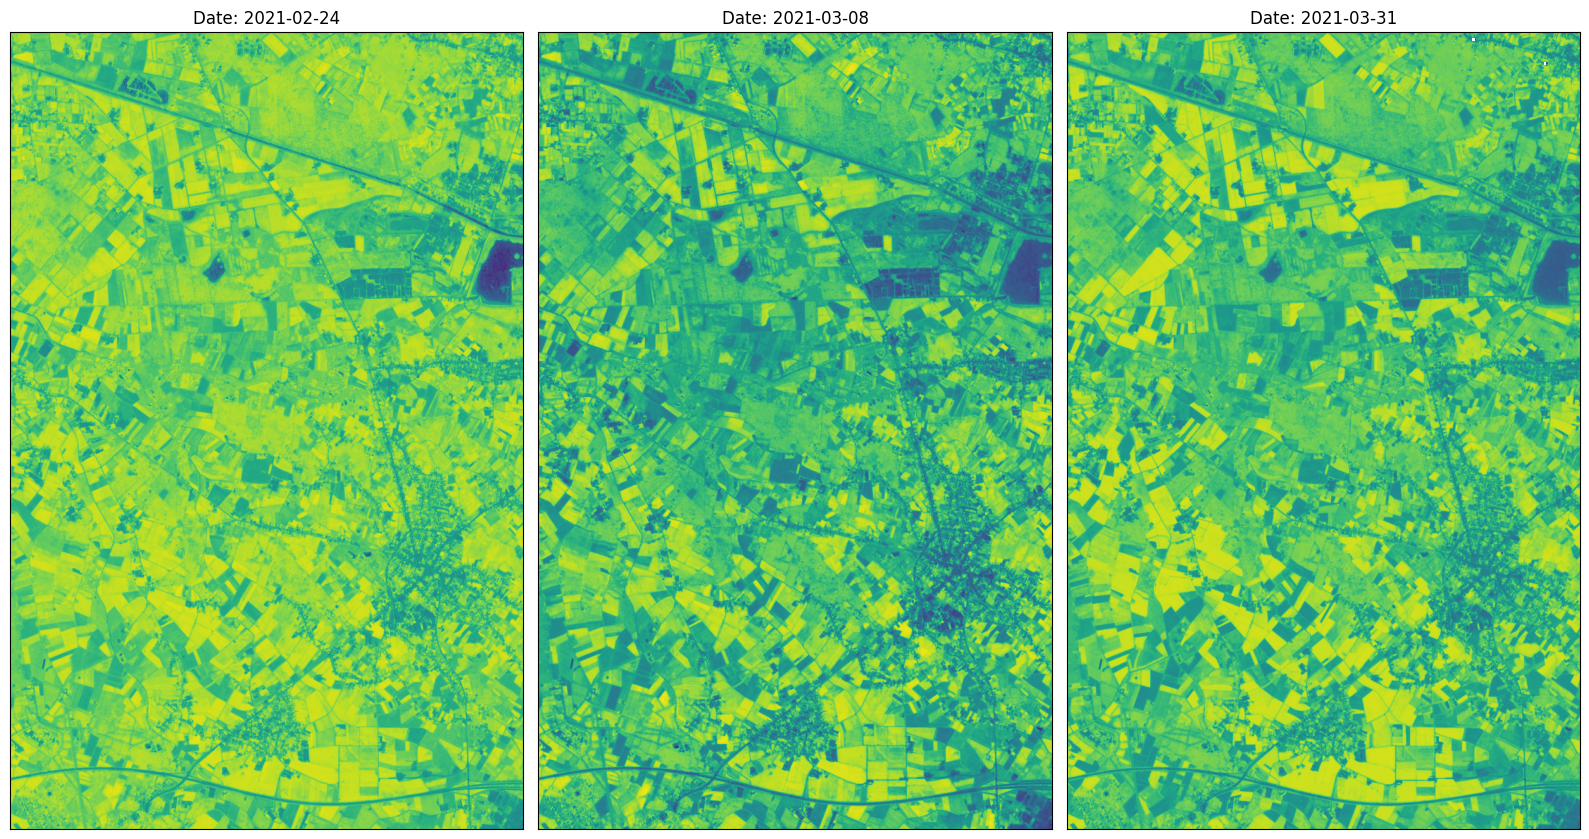

In [14]:
## Load your dataset
ndvi_data = xr.open_dataset(base_path / "ndvi.nc")

## Access the "var" variable
var = ndvi_data["var"]

## Select the top 3 time steps
three_steps = var["t"][0:3]

## Create a 1x3 horizontal plot for the top 3 time steps
plt.figure(figsize=(16, 10))  # Adjust the figure size as needed
for i, t in enumerate(three_steps):
    plt.subplot(1, 3, i + 1)
    data_slice = var.sel(t=t)
    dt = t.values.astype("M8[D]").astype("O")  # Convert to Python datetime object
    formatted_date = dt.strftime("%Y-%m-%d")  # Format the date
    plt.imshow(data_slice, cmap="viridis", origin="lower")
    plt.title(f"Date: {formatted_date}")
    # Hide both horizontal and vertical ticks and labels
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

## Close the dataset
ndvi_data.close()


## Apply a tensorflow neural network

We now apply a neural network, that requires 128x128 pixel 'chunks' input. To avoid discontinuities between neighboring chunks, we work with an overlap of 32 pixels in all directions. The U-Net itself is trained on an input size of (x,y,1), that is, just one grayscale channel as an input, which is just one NDVI tile. However, we are using 12 NDVI images as an input (the 12 images selected in the previous step). That is because we are doing inference using 3 different models, 4 times per model. The final prediction is then the median of all predictions per pixel.

As you may know, a U-Net just like any other CNN applies a filter over an image. This can be done using `apply_neighborhood`, an openEO process defined here: https://openeo.org/documentation/1.0/processes.html#apply_neighborhood .

Further preprocessing of the data and the inference logic of the models is coded in an UDF. 
UDF's are used to implement any custom code. It can therefore be used to quickly transfer code that you already wrote outside of openEO, or it can be used to implement features that are not present in openEO yet. It does however come at a cost of being slower than using openEO functionalities, due to optimization reasons.
UDF's are explained here: https://open-eo.github.io/openeo-python-client/udf.html

The pretrained models are stored as .onnx models. The onnxruntime package, and possible other dependencies, used in `udf_segmentation.py` has to be passed to the backend. This is done by passing a dependency archive as a job option, alongside the models.

In [13]:
dependencies_url = "https://artifactory.vgt.vito.be:443/auxdata-public/openeo/onnx_dependencies.zip"
models_url = "https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/openeo/parcelDelination/BelgiumCropMap_unet_3BandsGenerator_Models.zip"
job_options = {
    "udf-dependency-archives": [
        f"{dependencies_url}#onnx_deps",
        f"{models_url}#onnx_models",
    ]
}

In [14]:
## Apply the segmentation UDF using `apply_neighborhood`
## An overlap of 32px is used, resulting in a 128x128 pixel input
segmentationband = ndviband.apply_neighborhood(
    process=openeo.UDF.from_file("udf_segmentation.py"),
    size=[
        {"dimension": "x", "value": 64, "unit": "px"},
        {"dimension": "y", "value": 64, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 32, "unit": "px"},
        {"dimension": "y", "value": 32, "unit": "px"},
    ],
)

In [18]:
segmentation_job = segmentationband.create_job(
    title="segmentation_onnx_job", 
    out_format="NetCDF", 
    job_options=job_options
)
segmentation_job.start_and_wait()
segmentation_job.download_result(base_path / "delineation.nc")

0:00:00 Job 'vito-j-24010949b0a94214a1fa024e86736e86': send 'start'
0:00:25 Job 'vito-j-24010949b0a94214a1fa024e86736e86': queued (progress N/A)
0:00:31 Job 'vito-j-24010949b0a94214a1fa024e86736e86': queued (progress N/A)
0:00:38 Job 'vito-j-24010949b0a94214a1fa024e86736e86': queued (progress N/A)
0:00:46 Job 'vito-j-24010949b0a94214a1fa024e86736e86': queued (progress N/A)
0:00:56 Job 'vito-j-24010949b0a94214a1fa024e86736e86': queued (progress N/A)
0:01:09 Job 'vito-j-24010949b0a94214a1fa024e86736e86': queued (progress N/A)
0:01:25 Job 'vito-j-24010949b0a94214a1fa024e86736e86': queued (progress N/A)
0:01:45 Job 'vito-j-24010949b0a94214a1fa024e86736e86': queued (progress N/A)
0:02:09 Job 'vito-j-24010949b0a94214a1fa024e86736e86': queued (progress N/A)
0:02:40 Job 'vito-j-24010949b0a94214a1fa024e86736e86': queued (progress N/A)
0:03:18 Job 'vito-j-24010949b0a94214a1fa024e86736e86': running (progress N/A)
0:04:05 Job 'vito-j-24010949b0a94214a1fa024e86736e86': running (progress N/A)
0:05:0

<BatchJob job_id='vito-j-24010949b0a94214a1fa024e86736e86'>

The result of the U-Net is a map with more clearly defined boundaries, however the result is not optimal. We will therefore post-process our U-Net result by applying non-ML filters.


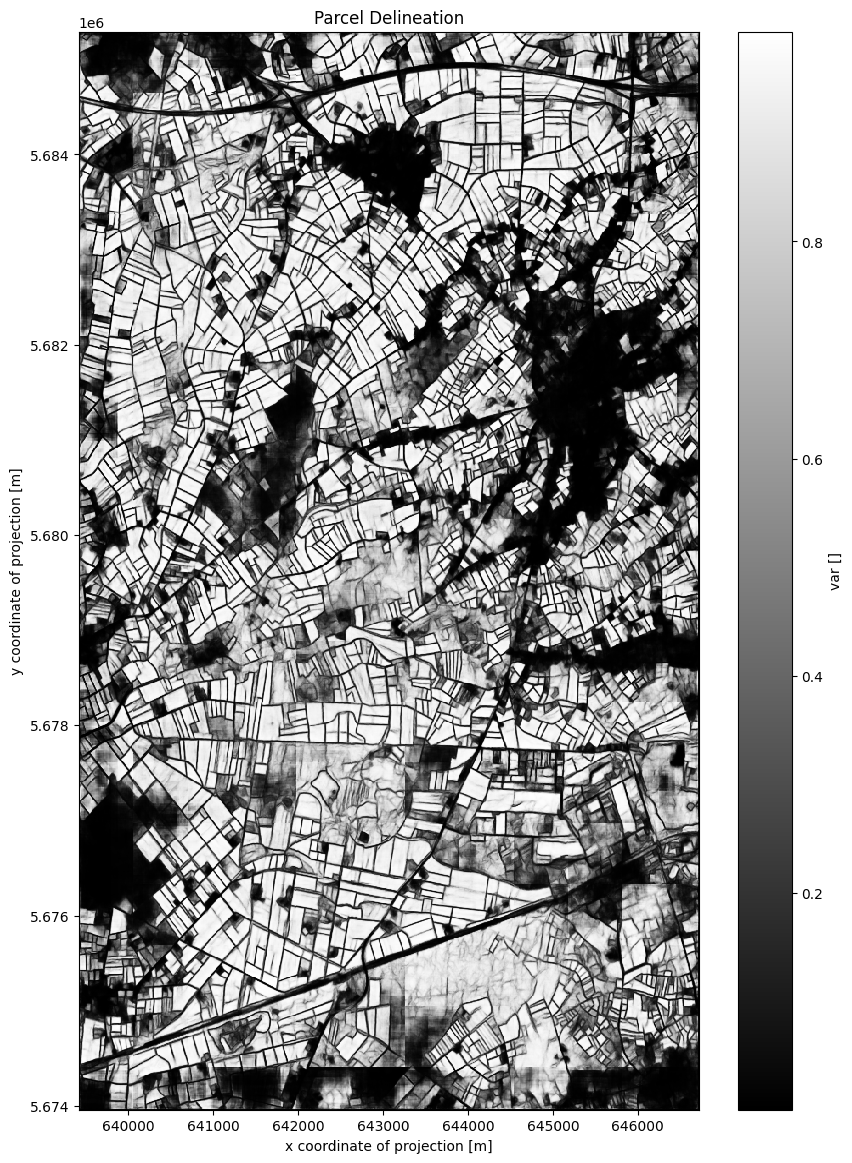

In [7]:
## Load your dataset
ds = xr.open_dataset(base_path / "delineation.nc")

## Access the "var" variable
var = ds["var"]

## Plot the data
var.plot(figsize=(10, 14), cmap="gray")  # Use a colormap that suits your data
plt.title("Parcel Delineation")
plt.show()

## Close the dataset
ds.close()

## Segmentation postprocessing

We postprocess the output from the neural network using a sobel filter and Felzenszwalb's algorithm, which are then merged. This time, we work on larger chunks, to reduce the need for stitching the vector output.

In [15]:
## Apply the sobel felzenszwalb UDF using `apply_neighborhood`
sobel_felzenszwalb = segmentationband.apply_neighborhood(
    process=openeo.UDF.from_file("udf_sobel_felzenszwalb.py"),
    size=[
        {"dimension": "x", "value": 256, "unit": "px"},
        {"dimension": "y", "value": 256, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 0, "unit": "px"},
        {"dimension": "y", "value": 0, "unit": "px"},
    ],
)

In [14]:
sobel_felzenszwalb_job = sobel_felzenszwalb.create_job(
    title="sobel_felzenszwalb",
    out_format="NetCDF",
    job_options=job_options
)
sobel_felzenszwalb_job.start_and_wait()
sobel_felzenszwalb_job.download_result(base_path / "delineation_filtered.nc")

<BatchJob job_id='vito-j-240109d054e2451490690bcb10094a47'>

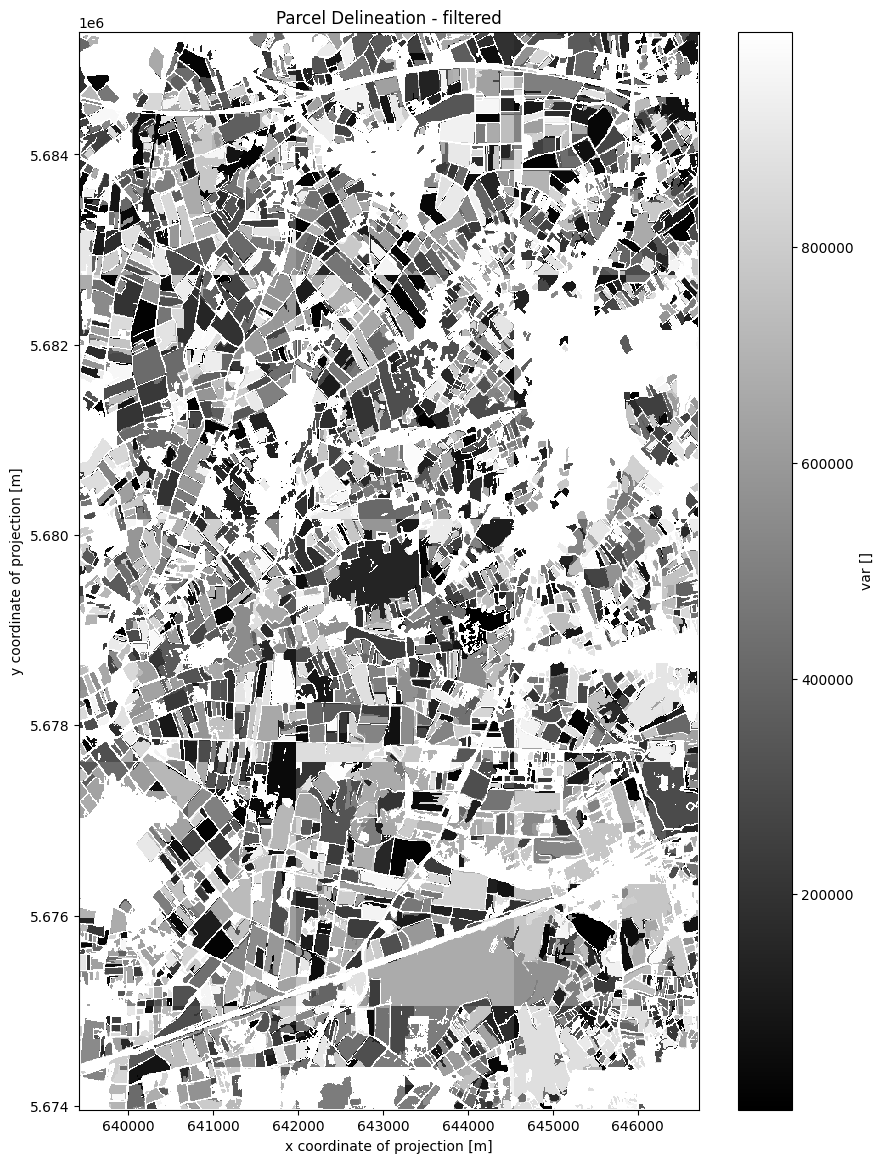

In [19]:
## Load your dataset
ds = xr.open_dataset(base_path / "delineation_filtered.nc")

## Access the "var" variable
var = ds["var"]

## Plot the data
var.plot(figsize=(10, 14), cmap="gray")  # Use a colormap that suits your data
plt.title("Parcel Delineation - filtered")
plt.show()

## Close the dataset
ds.close()

## Convert to vector

We are now ready to convert the raster image to vector. In openEO, we have an integrated process to do so, called `raster_to_vector`. You can read more about this method, or about other methods of interest, in our documentation: https://docs.openeo.cloud/processes/#raster_to_vector

In [17]:
## Convert the raster to a vector
vectorization = sobel_felzenszwalb.raster_to_vector()

In [18]:
vectorization_job = vectorization.create_job(
    title="vectorization",
    out_format="json",
    job_options=job_options
)
vectorization_job.start_and_wait()
vectorization_job.download_result(base_path / "parcels.json")

0:00:00 Job 'j-24010972d99941698ccf7f9999424f0f': send 'start'
0:00:21 Job 'j-24010972d99941698ccf7f9999424f0f': queued (progress N/A)
0:00:26 Job 'j-24010972d99941698ccf7f9999424f0f': queued (progress N/A)
0:00:32 Job 'j-24010972d99941698ccf7f9999424f0f': queued (progress N/A)
0:00:41 Job 'j-24010972d99941698ccf7f9999424f0f': queued (progress N/A)
0:00:51 Job 'j-24010972d99941698ccf7f9999424f0f': queued (progress N/A)
0:01:03 Job 'j-24010972d99941698ccf7f9999424f0f': queued (progress N/A)
0:01:19 Job 'j-24010972d99941698ccf7f9999424f0f': queued (progress N/A)
0:01:38 Job 'j-24010972d99941698ccf7f9999424f0f': queued (progress N/A)
0:02:03 Job 'j-24010972d99941698ccf7f9999424f0f': running (progress N/A)
0:02:33 Job 'j-24010972d99941698ccf7f9999424f0f': running (progress N/A)
0:03:10 Job 'j-24010972d99941698ccf7f9999424f0f': running (progress N/A)
0:03:57 Job 'j-24010972d99941698ccf7f9999424f0f': running (progress N/A)
0:04:55 Job 'j-24010972d99941698ccf7f9999424f0f': running (progress N

WindowsPath('results/parcels/parcels.json')

In [5]:
## Load the vector data as a GeoDataFrame
with open(base_path / "parcels.json") as f:
    polygons = json.load(f)
geom = [shape(p) for p in polygons]
parcels_gdf = gpd.GeoDataFrame(geometry=geom, crs="EPSG:32631")

## Save the GeoDataFrame to a file
parcels_gdf.to_file(str(base_path / "parcels.gpkg"), layer="parcels", driver="GPKG")

## Plot the data
parcels_gdf.plot(cmap="OrRd", figsize=(10, 16), edgecolor="black")
plt.title("Vector Parcels")
plt.show()

## Sampling

If you are training your own network, openEO can be used to get training data. In general, a workflow that is often used by researchers using our platform is:
* data access, data preparation, feature engineering and sampling: openEO
* model training: outside of openEO (e.g. on GPU's)
* model inference: in openEO using UDF's

In this notebook we are only doing inference. But to show you how to sample data, this is a small section on how that would work. When you are training a CNN, you will likely already have a set of images (e.g. for this use case, a number of delineated fields at a certain date, with a certain spatial extent). Sampling would therefore consist of:
* Loading in a collection, like we did before
* Calculating whatever index, raw band, custom calculation, or collection of one of the aforementioned you need for your use case
* Applying openEO processes `filter_spatial` and `filter_temporal` on your image corresponding to the labeled images you already have
* Downloading the results using `execute_batch()` or `send_job()` (batch processing), or `download()` (synchronous processing, if your images are fairly small)

If you are using a recurrent net or another ML model where your input is flat (for example, a random forest, a booster, an SVM, ...) and you are sampling points rather than entire images, you can use `filter_spatial` to filter your feature cube to the points for which you actually have sampling data, and the option `sample_by_feature=True` to store them as a separate record. You can do the same thing with `aggregate_spatial`. You can find more information [here](https://open-eo.github.io/openeo-python-client/cookbook/sampling.html) as well as a notebook where it is applied, [here](https://github.com/openEOPlatform/SRR2_notebooks/blob/main/UC3%20-%20Crop%20type%20feature%20engineering%20using%20random%20forest.ipynb).

In [30]:
s2_bands = eoconn.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=[startdate, enddate],
    bands=["B04", "B08", "SCL"],
    max_cloud_cover=20,
)
s2_bands = s2_bands.process("mask_scl_dilation", data=s2_bands, scl_band_name="SCL")

ndviband = s2_bands.ndvi(red="B04", nir="B08")
ndviband = ndviband.apply_dimension(
    process=openeo.UDF.from_file("udf_reduce_images.py"),
    dimension="t",
)

training_data = ndviband.filter_spatial(json.load(open("resources/training_parcels.geojson")))
training_data.execute_batch(
    outputfile=base_path / "training_data.nc",
    sample_by_feature=True,
)